# DL Project
## Stock Market Prediction 
In this project we will try to predict the stock market value using the dataset Stock Market Data of USA. 
We will use the LSTM model to predict the values of future stocks

**Index**: stock market index
**Date**: date of information recorded
**Open**: the price at which a stock starts trading.
**High**: show the high price a stock attained for a particular period of time.
**Low**: show the low price a stock attained for a particular period of time.
**Close**: The close is a reference to the end of a trading session in the financial markets when the markets close for the day
**Adj Close**: It is the price at which the last of the stock is bought or sold in the last trading session.
**Volume**: Volume is simply the number of shares traded in a particular stock, index, or other investment over a specific period of time.




In [ ]:
import pandas as pd

data = pd.read_excel('DL_Dataset.xlsx')

print(data)

In [ ]:
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  # Converte a coluna 'Date' para datetime

## Retirar duplicados e NA's

In [ ]:
data = data.dropna() # Remover valores nulos do 
data = data.drop_duplicates()

## Outliers


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Selecione apenas as colunas relevantes (preços)
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close']

# Criar um gráfico boxplot para visualizar outliers
plt.figure(figsize=(10,6))
sns.boxplot(data=data[price_columns])
plt.title('Boxplot dos Preços para Identificação de Outliers')
plt.xlabel('Tipo de Preço')
plt.ylabel('Valor')
plt.xticks(rotation=45)
plt.show()

Depois de verificar estes graficos, decidimos retirar os outliers

In [ ]:
# Definir as colunas que você quer verificar
price_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']

# Calcular o IQR para cada coluna
Q1 = data[price_columns].quantile(0.25)
Q3 = data[price_columns].quantile(0.75)
IQR = Q3 - Q1

# Filtrar para manter apenas os dados dentro do intervalo
data_clean = data[~((data[price_columns] < (Q1 - 1.5 * IQR)) | (data[price_columns] > (Q3 + 1.5 * IQR))).any(axis=1)]

print(f"Antes de remover outliers: {data.shape}")
print(f"Depois de remover outliers: {data_clean.shape}")

Aqui verificamos alguns dados estatisticos do dataset

In [ ]:
data_clean.describe()

In [ ]:
# Passar todos os valores para 2 casas decimais
data_clean['Open'] = data_clean['Open'].round(2)
data_clean['High'] = data_clean['High'].round(2)
data_clean['Low'] = data_clean['Low'].round(2)
data_clean['Close'] = data_clean['Close'].round(2)
data_clean['Volume'] = data_clean['Volume'].round(2)
data_clean['Adj Close'] = data_clean['Adj Close'].round(2)
print(data_clean)

In [ ]:
import matplotlib.pyplot as plt 
import seaborn as sns

sns.scatterplot(data = data_clean, x = 'Open', y = 'Close')
plt.title('Open vs Close')
plt.show()
sns.scatterplot(data = data_clean, x = 'High', y = 'Low')
plt.title('High vs Low')
plt.show()
sns.pairplot(data = data_clean)
plt.show()

In [ ]:
import seaborn as sns
import numpy as np

# Cálculo da correlação
corr = data_clean[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].corr()

# Criação do heatmap
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


In [ ]:
from sklearn.model_selection import train_test_split

y = data_clean[['Open', 'Close']]
X = data_clean.drop(columns=['Open', 'Close'])

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)
x_train.shape, x_test.shape

## Normalização

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Inicializando os escaladores
scaler_X = MinMaxScaler(feature_range=(0, 1))
scaler_y = MinMaxScaler(feature_range=(0, 1))

# Removendo as colunas 'Index' e 'Date' apenas para a normalização
x_train_scaled = scaler_X.fit_transform(x_train.drop(columns=['Index', 'Date']))
x_test_scaled = scaler_X.transform(x_test.drop(columns=['Index', 'Date']))

y_train_scaled = scaler_y.fit_transform(y_train)
y_test_scaled = scaler_y.transform(y_test)

# Verificando as dimensões dos dados escalonados
print(f"Tamanho de x_train_scaled: {x_train_scaled.shape}, Tamanho de x_test_scaled: {x_test_scaled.shape}")
print(f"Tamanho de y_train_scaled: {y_train_scaled.shape}, Tamanho de y_test_scaled: {y_test_scaled.shape}")

## Converter os dados para o formato adequado para o LSTM

In [ ]:
def create_dataset(X, y, time_step=60):
    """
    Converte os dados em sequências de forma que cada sequência tenha `time_step` entradas
    e um valor correspondente de saída para o próximo período.
    """
    X_seq, y_seq = [], []
    for i in range(len(X) - time_step):
        X_seq.append(X[i:(i + time_step), :])  # Sequência de entradas
        y_seq.append(y[i + time_step, :])      # Valor alvo para o próximo período
    return np.array(X_seq), np.array(y_seq)

# Criando as sequências para os dados de treino e teste
X_train_seq, y_train_seq = create_dataset(x_train_scaled, y_train_scaled, time_step=3000)
X_test_seq, y_test_seq = create_dataset(x_test_scaled, y_test_scaled, time_step=3000)

# Verificando as novas dimensões das sequências
print(f"Shape de X_train_seq: {X_train_seq.shape}, Shape de y_train_seq: {y_train_seq.shape}")


## Construir o modelo LSTM 

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Construindo o modelo LSTM
model = Sequential()

# Adicionando uma camada LSTM
model.add(LSTM(units=50, return_sequences=False, input_shape=(X_train_seq.shape[1], X_train_seq.shape[2])))

# Adicionando uma camada densa para gerar a saída
model.add(Dense(units=2))  # 'Open' e 'Close' são as duas variáveis que queremos prever

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Resumo do modelo
model.summary()


## Treinar o Modelo 

In [ ]:
# Treinando o modelo
model.fit(X_train_seq, y_train_seq, epochs=10, batch_size=32, validation_data=(X_test_seq, y_test_seq))

## Fazer as previsões e calcular a Loss e o RMSE

701/701 ━━━━━━━━━━━━━━━━━━━━ 99s 140ms/step
Previsão (Open, Close):  [-0.02148985 -0.02225455]
Real (Open, Close):  [0.02536197 0.02535996]
Loss (MSE): 0.10559189199563687
RMSE: 0.32494906061664014


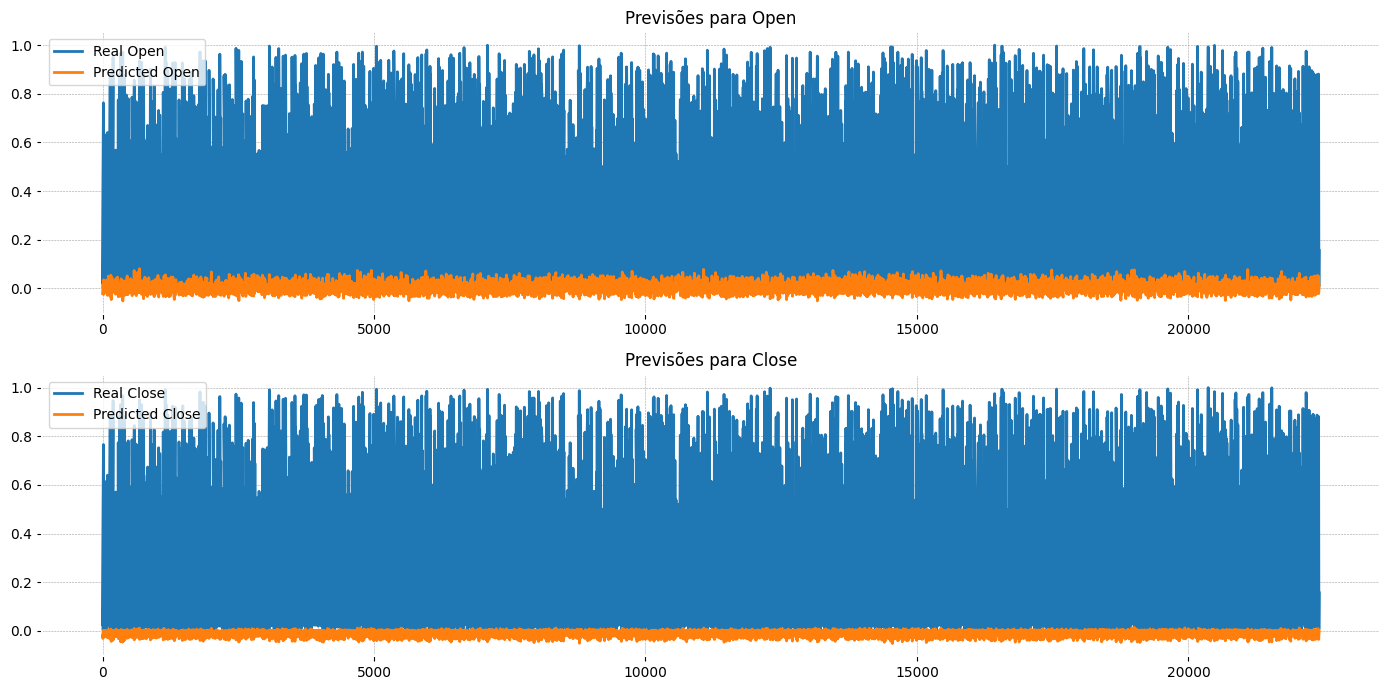

In [84]:
from sklearn.metrics import mean_squared_error
import numpy as np

# Fazendo previsões com o conjunto de teste
predictions = model.predict(X_test_seq)

# Desnormalizando as previsões e os valores reais
predictions = scaler_y.inverse_transform(predictions)
y_test_real = scaler_y.inverse_transform(y_test_seq)

# Calculando a loss (Erro Quadrático Médio) para as duas colunas
loss = mean_squared_error(y_test_real, predictions)

# Calculando o RQM (Root Mean Squared Error) para as duas colunas
rmse = np.sqrt(loss)

# Exemplo: comparando a previsão para o primeiro dia do conjunto de teste
print("Previsão (Open, Close): ", predictions[0])
print("Real (Open, Close): ", y_test_real[0])

# Exibindo a loss e o RQM
print(f"Loss (MSE): {loss}")
print(f"RMSE: {rmse}")

# Visualizando os resultados (gráfico) para ambas as variáveis 'Open' e 'Close'
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Visualizando a previsão para 'Open'
plt.subplot(2, 1, 1)
plt.plot(y_test_real[:, 0], label="Real Open")  # Valores reais de 'Open'
plt.plot(predictions[:, 0], label="Predicted Open")  # Previsões de 'Open'
plt.legend()
plt.title('Previsões para Open')

# Visualizando a previsão para 'Close'
plt.subplot(2, 1, 2)
plt.plot(y_test_real[:, 1], label="Real Close")  # Valores reais de 'Close'
plt.plot(predictions[:, 1], label="Predicted Close")  # Previsões de 'Close'
plt.legend()
plt.title('Previsões para Close')

plt.tight_layout()
plt.show()
